In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from IPython.display import display, FileLink
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.model_selection import KFold

# House prices predictions: linear model

This is a very simple introduction to Linear Regression with the Housing Prices Kaggle dataset. It aims to describe a very typical set of feature engineer steps for linear models, with lots of room to improve.

The high-level overview is as follows:

1. Download dataset.
2. Analyse and prepare dataset.
3. Train model.
4. Evaluate and submit results.

In [2]:
PATH = Path('./data')
PATH.mkdir(exist_ok=True)

## 1. Download dataset

The dataset can be downloaded using the Kaggle CLI tool. You can find installation instructions in the [kaggle-api](https://github.com/Kaggle/kaggle-api) repo. You'll also need to accept the terms and conditions of the project, which I've already done.

I can download it as follows:

In [3]:
!kaggle competitions download -c house-prices-advanced-regression-techniques -p {PATH}

data_description.txt: Skipping, found more recently modified local copy (use --force to force download)
train.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.gz: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


## 2. Analyse and prepare dataset

My goal here is to do the bare minimum EDA to get started with the competition. Let's start by loading and examining the dataset.

I use the transpose Pandas method to convert columns into rows, to make it easier to see everything.

In [3]:
df_raw = pd.read_csv(PATH / 'train.csv')

In [4]:
with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
    display(df_raw.head().transpose())

,0,1,2,3,4
Id,1,2,3,4,5
MSSubClass,60,20,60,70,60
MSZoning,RL,RL,RL,RL,RL
LotFrontage,65,80,68,60,84
LotArea,8450,9600,11250,9550,14260
Street,Pave,Pave,Pave,Pave,Pave
Alley,NaN,NaN,NaN,NaN,NaN
LotShape,Reg,Reg,IR1,IR1,IR1
LandContour,Lvl,Lvl,Lvl,Lvl,Lvl
Utilities,AllPub,AllPub,AllPub,AllPub,AllPub


### Find and remove outliers

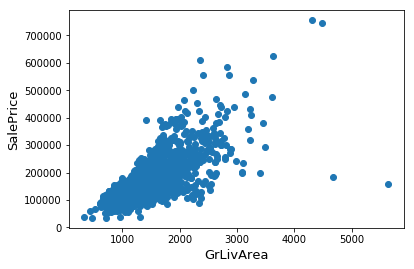

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = df_raw['GrLivArea'], y = df_raw['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [6]:
idx_to_drop = df_raw[(df_raw['GrLivArea']>4000) & (df_raw['SalePrice']<300000)].index
df_raw.drop(idx_to_drop, inplace=True)

### Extract and prepare target values

We know the target variable is going to be SalePrice, so I'll pop that off the data frame. The output expects the log of the predicted values, so we'll calculate that here too.

In [7]:
sale_price = df_raw.pop('SalePrice')
sale_price_log = np.log(sale_price)

In [8]:
sale_price_log.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

### Create features

In [9]:
df_raw['TotalSF'] = (df_raw['BsmtFinSF1'].fillna(0) + df_raw['BsmtFinSF2'].fillna(0) + df_raw['1stFlrSF'].fillna(0) + df_raw['2ndFlrSF'].fillna(0))

In [10]:
df_raw['TotalSF'].head()

0    2416
1    2240
2    2272
3    1933
4    2853
Name: TotalSF, dtype: int64

### Prepare columns

Since all inputs you pass into a machine learning model need to be numbers, we're going to need to make some decisions about how we prepare each column. With this dataset, there are really 3 types of column we need to consider:

* Continous columns: These are columns where each output is a unique number over a "continuous space", examples are lot area and lot frontage where each house will have a unique value. There are other continuous variables that may not be unique to each house, but nonetheless we can't categorise like year sold.
* Ordered categorical columns: These are columns that have small number of unique values but where the order matters. Good examples of these are `OverallQual`, which is a rating from 1 to 10.
* Unordered categorical columns: These are columns that are continuous but don't have any obvious ordering. `RoofStyle` might be a good example of this, though experienced property developers might be aware of some implicity ordering.

We'll start by removing the columns that aren't going to be useful for our model, like id which has nothing for the model to learn.

In [11]:
house_ids = df_raw.pop('Id')

We can easily find all continuous variables by collecting all columns that have a unique count above some threshold. 50 is a good place to start.

In [12]:
MAX_N_UNIQUE = 50

continuous_columns = set([
    col_name for col_name, col in df_raw.items()
    if len(col.unique()) > MAX_N_UNIQUE])

I can find a couple more columns that should be continuous by eyeing the description, so I'll add those in.

In [13]:
continuous_columns = list(continuous_columns | set([
    'LowQualFinSF', 'BsmtHalfBath', 'BsmtFullBath', 'FullBath',
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', '3SsnPorch',
    'PoolArea', 'MiscVal', 'Fireplaces', 'GarageCars']))

In [14]:
continuous_columns.remove('YearBuilt')
continuous_columns.remove('YearRemodAdd')

In [15]:
continuous_columns

['Fireplaces',
 'BedroomAbvGr',
 'GarageCars',
 'BsmtHalfBath',
 'GarageArea',
 'OpenPorchSF',
 'BsmtFullBath',
 '2ndFlrSF',
 'TotalSF',
 'LotArea',
 'MasVnrArea',
 'GarageYrBlt',
 '1stFlrSF',
 'HalfBath',
 'MiscVal',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'WoodDeckSF',
 'LotFrontage',
 'BsmtFinSF2',
 'LowQualFinSF',
 'BsmtFinSF1',
 'EnclosedPorch',
 'PoolArea',
 'TotRmsAbvGrd',
 'KitchenAbvGr',
 '3SsnPorch',
 'ScreenPorch',
 'GrLivArea',
 'FullBath']

The columns are all square feet measurements or years - sounds about right.

We can then treat all the remaining columns as categorical.

In [16]:
categorical_columns = [col for col in df_raw.columns if col not in continuous_columns]

In [17]:
assert len(df_raw.columns) == len(categorical_columns + continuous_columns)

### Prepare categorical

We prepare categorical variables by converting each using Panda's `astype('category')`:

In [18]:
for col_name, col in df_raw[categorical_columns].items():
    df_raw[col_name] = col.astype('category').cat.as_ordered()

We'll manually fix the ordering of any ordinal variables:

In [19]:
ordinal_column_data = [
    ('ExterQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('ExterCond', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('BsmtQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('BsmtExposure', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('BsmtFinType1', ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']),
    ('BsmtFinType2', ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']),
    ('HeatingQC', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('KitchenQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('FireplaceQu', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageFinish', ['Unf', 'Rfn', 'Fin']),
    ('GarageQual', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('GarageCond', ['Po', 'Fa', 'TA', 'Gd', 'Ex']),
    ('PoolQC', ['Fa', 'TA', 'Gd', 'Ex']),
    ('OverallQual', list(range(1, 11))),
    ('OverallCond', list(range(1, 11))),
    ('LandSlope', ['Sev', 'Mod', 'Gtl']),  # Assume less slope is better
    ('Functional', ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']),
    ('YearBuilt', list(range(1800, 2018))),
    ('YrSold', list(range(2006, 2018)))
]

ordinal_columns = [o[0] for o in ordinal_column_data]

for col, categories in ordinal_column_data:
    df_raw[col].cat.set_categories(categories, ordered=True, inplace=True)

For columns where there's no ordinal relationship, we'll do some special preprocessing later.

In [20]:
other_cat_columns = [col for col in categorical_columns if col not in ordinal_columns]

In [21]:
assert len(categorical_columns) == len(ordinal_columns + other_cat_columns)

### Prepare continuous

The first thing we'll want to do is replace all NaNs with some value. For some columns, a missing value is equivalent to 0. For others, we'll use the column's median. We can also add a column `isna` that will tell the model whether the value was originally missing or not.

We'll also want to save the median values to be used to replace nas in the test set.

In [22]:
nas = {}

In [23]:
for col in (
    'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath',
    'MasVnrArea'
):
    nas[col] = 0
    df_raw[col] = df_raw[col].fillna(0)
    df_raw[f'{col}_na'] = pd.isna(df_raw[col])

In [24]:
for col in continuous_columns:
    if not len(df_raw[df_raw[col].isna()]):
        continue
        
    median = df_raw[col].median()
        
    df_raw[f'{col}_na'] = pd.isna(df_raw[col])
    df_raw[col] = df_raw[col].fillna(median)
    
    nas[col] = median

Next, we'll deal with skew of the data. Machine learning models generally want data to be normally distributed. We can examine the skew of our features using the `skew` method.

In [25]:
skew_feats = df_raw[continuous_columns].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_feats.head(10)

MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
dtype: float64

/Users/lex/code/notebooks/kaggle/house-prices-advanced-regression-techniques/ENV/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


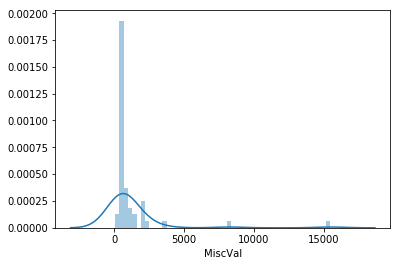

In [26]:
sns.distplot(df_raw[df_raw['MiscVal'] != 0]['MiscVal'])

We can unskew the features using the Box-Cox transformation.

In [27]:
skew_feats = skew_feats[abs(skew_feats) > 0.75]

lam = 0.15
for feat in skew_feats.index:
    df_raw[feat] = boxcox1p(df_raw[feat], lam)

/Users/lex/code/notebooks/kaggle/house-prices-advanced-regression-techniques/ENV/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


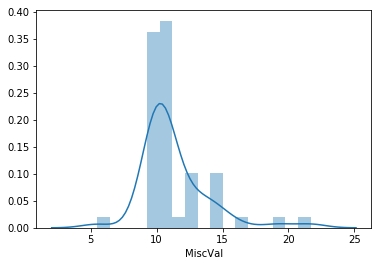

In [28]:
sns.distplot(df_raw[df_raw['MiscVal'] != 0]['MiscVal'])

### Numericalise

Last thing we want to do is convert all categories into their numeric representation.

In [29]:
df_numeric = df_raw.copy()

Then create a one-hot encoding for the other categorical columns.

In [30]:
dummies = pd.get_dummies(df_numeric[other_cat_columns], dummy_na=True)

In [31]:
for col_name in categorical_columns:
    # Use +1 to push the -1 NaN value to 0
    df_numeric[col_name] = df_numeric[col_name].cat.codes + 1

Add the one hot encodings.

In [32]:
df_numeric.drop(other_cat_columns, axis=1, inplace=True)
df_numeric = pd.concat([df_numeric, dummies], axis=1)

### Create validation set

We want to create a validation set that's as similar as possible to the test set provided by Kaggle.

We can use the `train_test_split` function to do that.

In [33]:
X_train, X_val, y_train, y_val = train_test_split(df_numeric, sale_price_log, test_size=0.2, random_state=42, shuffle=True)

## 3. Train evaluate model

Now comes the easy part. We can train the model in 2 lines:

In [34]:
model = Lasso(alpha=0.0004)

In [35]:
model.fit(X_train, y_train)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
print(model.score(X_train, y_train))
print(model.score(X_val, y_val))

0.9431976859103168
0.9271233837889473


### Basic evaluation

In [37]:
preds = model.predict(X_val)

In [38]:
rms = sqrt(((y_val - preds) ** 2).mean())
print(f'RMSE: {rms}')

RMSE: 0.11083971646470499


### KFolds Cross validation

In [39]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
model = Lasso(alpha=0.0004)
scores = np.sqrt(
    -cross_val_score(model, df_numeric, sale_price_log, cv=kf, scoring='neg_mean_squared_error'))

In [40]:
scores.mean()

0.10823090450777259

Finally, we'll train the model on the whole training set and submit the predictions.

In [41]:
final_model = Lasso(alpha=0.0004)
final_model.fit(df_numeric, sale_price_log)

Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

## 4. Submit predictions

We now need to prepare the test set using exactly the same preparation we used with the training data.

In [42]:
df_test_raw = pd.read_csv(PATH / 'test.csv')

In [43]:
house_ids = df_test_raw.pop('Id')

In [44]:
df_test_raw['TotalSF'] = (df_test_raw['BsmtFinSF1'].fillna(0) + df_test_raw['BsmtFinSF2'].fillna(0) + df_test_raw['1stFlrSF'].fillna(0) + df_test_raw['2ndFlrSF'].fillna(0))

In [45]:
for col_name in categorical_columns:
    df_test_raw[col_name] = (
        pd.Categorical(df_test_raw[col_name], categories=df_raw[col_name].cat.categories, ordered=True))

In [46]:
for col in continuous_columns:
    if col not in nas:
        continue

    df_test_raw[f'{col}_na'] = pd.isna(df_test_raw[col])
    df_test_raw[col] = df_test_raw[col].fillna(nas[col])

In [47]:
# Handle any other nas
df_test_raw[continuous_columns] = df_test_raw[continuous_columns].fillna(df_test_raw[continuous_columns].median())

In [48]:
for feat in skew_feats.index:
    df_test_raw[feat] = boxcox1p(df_test_raw[feat], lam)

In [49]:
df_test = df_test_raw.copy()

In [50]:
test_dummies = pd.get_dummies(df_test[other_cat_columns], dummy_na=True)

In [51]:
for col_name in categorical_columns:
    # Use +1 to push the -1 NaN value to 0
    df_test[col_name] = df_test[col_name].cat.codes + 1

In [52]:
df_test.drop(other_cat_columns, axis=1, inplace=True)
df_test = pd.concat([df_test, test_dummies], axis=1)

In [53]:
test_preds = final_model.predict(df_test)

In [54]:
pd.DataFrame({'Id': house_ids, 'SalePrice': np.exp(test_preds)}).to_csv(f'{PATH}/sub_date_categorical.csv', index=False)

In [55]:
FileLink(str(PATH / 'sub_date_categorical.csv'))

/Users/lex/code/notebooks/kaggle/house-prices-advanced-regression-techniques/data/sub_date_categorical.csv

<img src="./images/submission-11.png">

That's put me in the top 14% - pretty damn good for Linear Regression.

## 5. Save prepared dataframes

In [56]:
df_numeric.reset_index().to_feather(PATH / 'df_numeric')
sale_price_log.reset_index().to_feather(PATH / 'sale_price_log')
df_test.reset_index().to_feather(PATH / 'df_test')
house_ids.reset_index().to_feather(PATH / 'test_house_ids')